# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=65,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_17-31-59/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5030 | MulticlassF1Score=0.1317
Batch-30 : CrossEntropyLoss=2.4924 | MulticlassF1Score=0.1905
Batch-45 : CrossEntropyLoss=2.4342 | MulticlassF1Score=0.2546
Batch-60 : CrossEntropyLoss=2.4025 | MulticlassF1Score=0.3223
Batch-75 : CrossEntropyLoss=2.4159 | MulticlassF1Score=0.3664
Batch-90 : CrossEntropyLoss=2.3868 | MulticlassF1Score=0.3977
Batch-105: CrossEntropyLoss=2.3700 | MulticlassF1Score=0.4227
Batch-120: CrossEntropyLoss=2.3863 | MulticlassF1Score=0.4417
Batch-135: CrossEntropyLoss=2.3800 | MulticlassF1Score=0.4562
Batch-150: CrossEntropyLoss=2.3682 | MulticlassF1Score=0.4669
Batch-165: CrossEntropyLoss=2.3410 | MulticlassF1Score=0.4847
Batch-180: CrossEntropyLoss=2.3668 | MulticlassF1Score=0.5000
Batch-195: CrossEntropyLoss=2.3545 | MulticlassF1Score=0.5131
Batch-210: CrossEntropyLoss=2.3493 | MulticlassF1Score=0.5253
Batch-225: CrossEntropyLoss=2.3232 | MulticlassF1Score=0.5392
Batch-226: CrossEntropyLoss=2.3433 | MulticlassF1Score=0.5397

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3172 | MulticlassF1Score=0.7472
Batch-30 : CrossEntropyLoss=2.3221 | MulticlassF1Score=0.7484
Batch-45 : CrossEntropyLoss=2.3407 | MulticlassF1Score=0.7481
Batch-60 : CrossEntropyLoss=2.3284 | MulticlassF1Score=0.7483
Batch-63 : CrossEntropyLoss=2.3297 | MulticlassF1Score=0.7487

Training   : Mean CrossEntropyLoss = 2.4016 | Mean MulticlassF1Score = 0.3865
Validation : Mean CrossEntropyLoss = 2.3297 | Mean MulticlassF1Score = 0.7473

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3405 | MulticlassF1Score=0.7544
Batch-30 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7672
Batch-45 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.7721
Batch-60 : CrossEntropyLoss=2.3213 | MulticlassF1Score=0.7754
Batch-75 : CrossEntropyLoss=2.3071 | MulticlassF1Score=0.7778
Batch-90 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7791
Batch-105: CrossEntropyLoss=2.3202 | MulticlassF1Score=0.7802
Batch-120: CrossEntropyLoss=2.3090 | MulticlassF1Score=0.7811
Batch-135: CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7816
Batch-150: CrossEntropyLoss=2.3106 | MulticlassF1Score=0.7823
Batch-165: CrossEntropyLoss=2.3200 | MulticlassF1Score=0.7822
Batch-180: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.7827
Batch-195: CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7832
Batch-210: CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7837
Batch-225: CrossEntropyLoss=2.3121 | MulticlassF1Score=0.7844
Batch-226: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7845

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3186 | MulticlassF1Score=0.7841
Batch-30 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.7836
Batch-45 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7867
Batch-60 : CrossEntropyLoss=2.3236 | MulticlassF1Score=0.7901
Batch-63 : CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7901

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3154 | Mean MulticlassF1Score = 0.7770
Validation : Mean CrossEntropyLoss = 2.3134 | Mean MulticlassF1Score = 0.7866

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.7996
Batch-30 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7945
Batch-45 : CrossEntropyLoss=2.3099 | MulticlassF1Score=0.7945
Batch-60 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7946
Batch-75 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.7948
Batch-90 : CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7953
Batch-105: CrossEntropyLoss=2.3203 | MulticlassF1Score=0.7945
Batch-120: CrossEntropyLoss=2.3205 | MulticlassF1Score=0.7951
Batch-135: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.7946
Batch-150: CrossEntropyLoss=2.3227 | MulticlassF1Score=0.7944
Batch-165: CrossEntropyLoss=2.3148 | MulticlassF1Score=0.7941
Batch-180: CrossEntropyLoss=2.3083 | MulticlassF1Score=0.7937
Batch-195: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.7945
Batch-210: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.7962
Batch-225: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.7973
Batch-226: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.7973

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8153
Batch-30 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8132
Batch-45 : CrossEntropyLoss=2.3157 | MulticlassF1Score=0.8098
Batch-60 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8112
Batch-63 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8113

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3108 | Mean MulticlassF1Score = 0.7952
Validation : Mean CrossEntropyLoss = 2.3064 | Mean MulticlassF1Score = 0.8126

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3120 | MulticlassF1Score=0.8129
Batch-30 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8200
Batch-45 : CrossEntropyLoss=2.3174 | MulticlassF1Score=0.8205
Batch-60 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8221
Batch-75 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8229
Batch-90 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8228
Batch-105: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8239
Batch-120: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8249
Batch-135: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8259
Batch-150: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8266
Batch-165: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8271
Batch-180: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8272
Batch-195: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8269
Batch-210: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8271
Batch-225: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8270
Batch-226: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8271

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8253
Batch-30 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8255
Batch-45 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8234
Batch-60 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8252
Batch-63 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8254

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8238
Validation : Mean CrossEntropyLoss = 2.3020 | Mean MulticlassF1Score = 0.8230

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8312
Batch-30 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8303
Batch-45 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8295
Batch-60 : CrossEntropyLoss=2.3173 | MulticlassF1Score=0.8281
Batch-75 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8292
Batch-90 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8301
Batch-105: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8298
Batch-120: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8293
Batch-135: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8294
Batch-150: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8296
Batch-165: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8296
Batch-180: CrossEntropyLoss=2.3109 | MulticlassF1Score=0.8294
Batch-195: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8299
Batch-210: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8304
Batch-225: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8308
Batch-226: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8310

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8199
Batch-30 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8231
Batch-45 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8256
Batch-60 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8264
Batch-63 : CrossEntropyLoss=2.3099 | MulticlassF1Score=0.8269

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3001 | Mean MulticlassF1Score = 0.8296
Validation : Mean CrossEntropyLoss = 2.3014 | Mean MulticlassF1Score = 0.8243

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8280
Batch-30 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8314
Batch-45 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8320
Batch-60 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8338
Batch-75 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8326
Batch-90 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8322
Batch-105: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8322
Batch-120: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8324
Batch-135: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8328
Batch-150: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8329
Batch-165: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8333
Batch-180: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8326
Batch-195: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8329
Batch-210: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8333
Batch-225: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8340
Batch-226: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8340

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8355
Batch-30 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8358
Batch-45 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8335
Batch-60 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8357
Batch-63 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8359

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2991 | Mean MulticlassF1Score = 0.8321
Validation : Mean CrossEntropyLoss = 2.2987 | Mean MulticlassF1Score = 0.8332

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8368
Batch-30 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8419
Batch-45 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8415
Batch-60 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8414
Batch-75 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8414
Batch-90 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8413
Batch-105: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8416
Batch-120: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8414
Batch-135: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8413
Batch-150: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8415
Batch-165: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8416
Batch-180: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8412
Batch-195: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8415
Batch-210: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8418
Batch-225: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8416
Batch-226: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8415

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8390
Batch-30 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8396
Batch-45 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8369
Batch-60 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8367
Batch-63 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8361

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2967 | Mean MulticlassF1Score = 0.8411
Validation : Mean CrossEntropyLoss = 2.2985 | Mean MulticlassF1Score = 0.8385

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8422
Batch-30 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8438
Batch-45 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8472
Batch-60 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8514
Batch-75 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8522
Batch-90 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8531
Batch-105: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8533
Batch-120: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8533
Batch-135: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8541
Batch-150: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8551
Batch-165: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8555
Batch-180: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8556
Batch-195: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8556
Batch-210: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8559
Batch-225: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8559
Batch-226: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8559

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8542
Batch-30 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8528
Batch-45 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8522
Batch-60 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8518
Batch-63 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8521

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2925 | Mean MulticlassF1Score = 0.8520
Validation : Mean CrossEntropyLoss = 2.2936 | Mean MulticlassF1Score = 0.8525

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8625
Batch-30 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8605
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8603
Batch-60 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8619
Batch-75 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8620
Batch-90 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8612
Batch-105: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8611
Batch-120: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8607
Batch-135: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8602
Batch-150: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8606
Batch-165: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8604
Batch-180: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8605
Batch-195: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8603
Batch-210: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8603
Batch-225: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8605
Batch-226: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8604

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8564
Batch-30 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8576
Batch-45 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8546
Batch-60 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8539
Batch-63 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8540

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2909 | Mean MulticlassF1Score = 0.8612
Validation : Mean CrossEntropyLoss = 2.2932 | Mean MulticlassF1Score = 0.8561

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8637
Batch-30 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8625
Batch-45 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8632
Batch-60 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8625
Batch-75 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8630
Batch-90 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8640
Batch-105: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8644
Batch-120: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8642
Batch-135: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8642
Batch-150: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8634
Batch-165: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8631
Batch-180: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8627
Batch-195: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8629
Batch-210: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8627
Batch-225: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8629
Batch-226: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8630

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8710
Batch-30 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8712
Batch-45 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8698
Batch-60 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8694
Batch-63 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8682

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2901 | Mean MulticlassF1Score = 0.8634
Validation : Mean CrossEntropyLoss = 2.2890 | Mean MulticlassF1Score = 0.8707

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8820
Batch-30 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8867
Batch-45 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8890
Batch-60 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8888
Batch-75 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8877
Batch-90 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8879
Batch-105: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8883
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8883
Batch-135: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8889
Batch-150: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8887
Batch-165: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8890
Batch-180: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8896
Batch-195: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8890
Batch-210: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8891
Batch-225: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.8894
Batch-226: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8893

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8872
Batch-30 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8849
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8830
Batch-60 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8821
Batch-63 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8823

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2822 | Mean MulticlassF1Score = 0.8875
Validation : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8846

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8899
Batch-30 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8925
Batch-45 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8936
Batch-60 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8943
Batch-75 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8939
Batch-90 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8938
Batch-105: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8940
Batch-120: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8939
Batch-135: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8934
Batch-150: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8930
Batch-165: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8932
Batch-180: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8930
Batch-195: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8932
Batch-210: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8933
Batch-225: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8930
Batch-226: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8929

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8797
Batch-30 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8792
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8803
Batch-60 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8813
Batch-63 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8820

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2810 | Mean MulticlassF1Score = 0.8931
Validation : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8802

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8907
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.8923
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8930
Batch-60 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8937
Batch-75 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8942
Batch-90 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8940
Batch-105: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8944
Batch-120: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8952
Batch-135: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8950
Batch-150: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8952
Batch-165: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8951
Batch-180: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8951
Batch-195: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8946
Batch-210: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8947
Batch-225: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.8958
Batch-226: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8959

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9044
Batch-30 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.9038
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9052
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9050
Batch-63 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9049

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8941
Validation : Mean CrossEntropyLoss = 2.2779 | Mean MulticlassF1Score = 0.9044

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9155
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9172
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9195
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9209
Batch-75 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9216
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9225
Batch-105: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9223
Batch-120: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9224
Batch-135: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9232
Batch-150: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9231
Batch-165: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9229
Batch-180: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9236
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9236
Batch-210: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9239
Batch-225: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9237
Batch-226: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9237

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9123
Batch-30 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9119
Batch-45 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9108
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9117
Batch-63 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9115

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9212
Validation : Mean CrossEntropyLoss = 2.2753 | Mean MulticlassF1Score = 0.9130

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9279
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9258
Batch-75 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9265
Batch-90 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9268
Batch-105: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9271
Batch-120: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9272
Batch-135: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9269
Batch-150: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9272
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9277
Batch-180: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9271
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9271
Batch-210: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9267
Batch-225: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9264
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9264

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9152
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9139
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9134
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9129
Batch-63 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9125

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9266
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9138

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9290
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9287
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9280
Batch-75 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9282
Batch-90 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9283
Batch-105: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9275
Batch-120: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9275
Batch-135: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9272
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9281
Batch-165: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9282
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9284
Batch-195: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9280
Batch-210: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9275
Batch-225: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9277
Batch-226: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9277

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9222
Batch-30 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9159
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9139
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9139
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9136

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9279
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9173

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9287
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9297
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9284
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9279
Batch-75 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9275
Batch-90 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9275
Batch-105: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9277
Batch-120: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9280
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9286
Batch-150: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9283
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9283
Batch-180: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9280
Batch-195: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9280
Batch-210: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9283
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9287
Batch-226: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9287

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9105
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9130
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9136
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9124
Batch-63 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9126

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9284
Validation : Mean CrossEntropyLoss = 2.2748 | Mean MulticlassF1Score = 0.9118

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9327
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9286
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9290
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9288
Batch-75 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9289
Batch-90 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9287
Batch-105: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9287
Batch-120: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9290
Batch-135: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9294
Batch-150: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9292
Batch-165: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9293
Batch-180: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9296
Batch-195: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9296
Batch-210: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9294
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9296
Batch-226: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9297

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9154
Batch-30 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9160
Batch-45 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9141
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9138
Batch-63 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9134

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9294
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9152

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9278
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9277
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9297
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9301
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9307
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9306
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9309
Batch-120: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9317
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9314
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9309
Batch-165: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9309
Batch-180: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9307
Batch-195: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9302
Batch-210: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9301
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9302
Batch-226: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9302

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9197
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9143
Batch-45 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9149
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9132
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9136

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9302
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9167

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9308
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9301
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9314
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9303
Batch-75 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9303
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9310
Batch-105: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9312
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9316
Batch-135: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9311
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9309
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9309
Batch-180: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9308
Batch-195: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9310
Batch-210: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9310
Batch-225: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9309
Batch-226: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9308

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9128
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9130
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9127
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9131
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9135

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9308
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9123

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9321
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9302
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9301
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9305
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9306
Batch-90 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9309
Batch-105: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9318
Batch-120: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9317
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9318
Batch-150: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9315
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9313
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9314
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9314
Batch-210: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9313
Batch-225: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9312
Batch-226: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9312

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9150
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9150
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9132
Batch-60 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9135
Batch-63 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9132

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9314
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9147

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9311
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9320
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9319
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9317
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9322
Batch-90 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9319
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9315
Batch-120: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9315
Batch-135: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9311
Batch-150: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9312
Batch-165: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9314
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9316
Batch-195: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9320
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9317
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9316
Batch-226: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9316

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9147
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9125
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9135
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9135
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9136

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9314
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9117

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9306
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9319
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9323
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9328
Batch-75 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9316
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9320
Batch-105: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9314
Batch-120: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9308
Batch-135: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9313
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9314
Batch-165: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9314
Batch-180: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9316
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9319
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9323
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9328
Batch-226: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9328

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9174
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9185
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9179
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9173
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9176

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9319
Validation : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9194

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9352
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9354
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9351
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9352
Batch-75 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9349
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9349
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9347
Batch-120: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9354
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9356
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9356
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9358
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9357
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9361
Batch-210: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9360
Batch-225: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9360
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9360

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9153
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9177
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9191
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9192
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9191

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9353
Validation : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9170

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9361
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9377
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9376
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9368
Batch-75 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9366
Batch-90 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9371
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9376
Batch-120: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9372
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9373
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9372
Batch-165: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9371
Batch-180: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9375
Batch-195: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9374
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9374
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9374
Batch-226: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9373

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9222
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9205
Batch-60 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9196
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9196

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9370
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9223

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9390
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9382
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9388
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9383
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9388
Batch-90 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9382
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9381
Batch-120: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9379
Batch-135: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9385
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9399
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9413
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9426
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9439
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9449
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9455
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9456

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9415
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9402
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9395
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9393

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9403
Validation : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9392

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9574
Batch-30 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9599
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9590
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9586
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9583
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9582
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9581
Batch-120: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9586
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9581
Batch-150: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9586
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9585
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9582
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9582
Batch-210: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9582
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9584
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9584

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9425
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9409
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9400
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9391
Batch-63 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9390

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9584
Validation : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9411

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9608
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9592
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9588
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9587
Batch-75 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9590
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9590
Batch-105: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9588
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9584
Batch-135: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9589
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9592
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9592
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9593
Batch-195: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9589
Batch-210: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9588
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9590
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9590

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9398
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9406
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9401
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9395

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2602 | Mean MulticlassF1Score = 0.9592
Validation : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9397

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9598
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9590
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9593
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9598
Batch-75 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9594
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9591
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9588
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9590
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9593
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9597
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9598
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9597
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9597
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9598
Batch-225: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9597
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9597

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9366
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9398
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9403
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9407

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2599 | Mean MulticlassF1Score = 0.9594
Validation : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9387

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9621
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9607
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9597
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9600
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9604
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9606
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9605
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9604
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9602
Batch-150: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9605
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9609
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9608
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9606
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9605
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9602
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9602

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9432
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9422
Batch-60 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9416
Batch-63 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9414

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2598 | Mean MulticlassF1Score = 0.9607
Validation : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9422

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9624
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9599
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9607
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9606
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9609
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9614
Batch-105: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9611
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9613
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9616
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9615
Batch-165: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9613
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9612
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9612
Batch-210: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9612
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9610
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9609

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9397
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9404
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9409
Batch-63 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9405

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2596 | Mean MulticlassF1Score = 0.9613
Validation : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9406

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9612
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9609
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9608
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9601
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9600
Batch-90 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9607
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9609
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9603
Batch-135: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9581
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9574
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9570
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9568
Batch-195: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9567
Batch-210: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9566
Batch-225: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9562
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9562

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9384
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9385
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9402
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9408
Batch-63 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9407

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2619 | Mean MulticlassF1Score = 0.9589
Validation : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9395
Patience = 1/50❗

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9582
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9565
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9567
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9580
Batch-75 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9577
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9578
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9580
Batch-120: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9582
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9584
Batch-150: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9585
Batch-165: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9581
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9582
Batch-195: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9582
Batch-210: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9584
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9584
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9584

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9416
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9428
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9419
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9419

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9582
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9426

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9638
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9631
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9620
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9617
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9611
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9610
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9611
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9608
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9609
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9608
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9608
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9610
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9611
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9609
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9613
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9613

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9416
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9430
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9430

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2595 | Mean MulticlassF1Score = 0.9615
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9430

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9648
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9645
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9640
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9634
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9632
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9634
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9634
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9637
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9636
Batch-150: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9635
Batch-165: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9633
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9635
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9633
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9630
Batch-225: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9630
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9629

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9436
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9432
Batch-63 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9433

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9637
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9438

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9640
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9627
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9633
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9639
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9638
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9633
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9635
Batch-120: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9637
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9637
Batch-150: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9636
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9636
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9635
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9636
Batch-210: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9637
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9638
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9638

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9416
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9432
Batch-63 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9433

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9635
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9419

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9664
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9644
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9637
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9637
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9628
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9627
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9633
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9634
Batch-135: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9638
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9641
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9643
Batch-180: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9641
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9641
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9640
Batch-225: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9642
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9642

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9431
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9434
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9435

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9639
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9423

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9622
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9643
Batch-45 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9645
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9647
Batch-75 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9648
Batch-90 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9644
Batch-105: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9642
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9647
Batch-135: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9651
Batch-150: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9647
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9649
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9650
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9648
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9648
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9648
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9648

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9441
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9441

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9645
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9441

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9658
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9642
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9645
Batch-60 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9641
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9642
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9646
Batch-105: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9649
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9652
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9651
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9651
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9652
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9652
Batch-210: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9652
Batch-225: CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9652
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9652

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9399
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9442
Batch-63 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9444

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9649
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9424

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9660
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9658
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9652
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9652
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9651
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9651
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9651
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9654
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9656
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9656
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9656
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9655
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9655
Batch-226: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9654

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9442
Batch-63 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9442

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9657
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9458

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9653
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9655
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9650
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9657
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9656
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9654
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9652
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9651
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9650
Batch-180: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9652
Batch-195: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9656
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9654
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9656
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9444
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9437
Batch-63 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9439

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9656
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9442

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9659
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9652
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9649
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9650
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9649
Batch-90 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9648
Batch-105: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9650
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9655
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9655
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9655
Batch-165: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9655
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9658
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9658
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9658
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9657
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9430
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9444
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9445

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9653
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9444
Patience = 2/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9648
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9647
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9657
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9654
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9656
Batch-90 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9657
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9657
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9658
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9658
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9661
Batch-165: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9662
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9656
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9655
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9650
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9653
Batch-226: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9653

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9394
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9427
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9426

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9655
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9408
Patience = 3/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9611
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9639
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9633
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9640
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9643
Batch-90 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9646
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9644
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9644
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9644
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9643
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9644
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9645
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9645
Batch-210: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9643
Batch-225: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9644
Batch-226: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9644

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9437
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9433
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9438
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9432
Batch-63 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9432

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9640
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9436
Patience = 4/50❗

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9640
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9640
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9642
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9640
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9648
Batch-90 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9645
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9650
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9647
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9647
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9644
Batch-165: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9644
Batch-180: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9641
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9638
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9638
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9638
Batch-226: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9639

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9438
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9431
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9429

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9643
Validation : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9438
Patience = 5/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9646
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9655
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9662
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9655
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9658
Batch-90 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9657
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9657
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9653
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9650
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9648
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9644
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9641
Batch-195: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9641
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9640
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9642
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9641

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9426
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9434
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9437

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9650
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9442

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9641
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9651
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9649
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9656
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9653
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9650
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9654
Batch-150: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9657
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9655
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9653
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9653
Batch-210: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9650
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9649
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9649

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9431
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9426
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9436
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9432

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9652
Validation : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9439

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9668
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9655
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9642
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9645
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9648
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9646
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9649
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9653
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9651
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9650
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9652
Batch-195: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9652
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9653
Batch-225: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9653
Batch-226: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9654

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9437
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9437
Batch-63 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9437

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9652
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9433

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9657
Batch-30 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9673
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9668
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9666
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9660
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9660
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9662
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9663
Batch-135: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9663
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9662
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9662
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9662
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9664
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9662
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9660
Batch-226: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9659

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9438
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9437

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9664
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9430

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9641
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9645
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9647
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9649
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9653
Batch-90 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9656
Batch-105: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9661
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9661
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9662
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9667
Batch-180: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9666
Batch-195: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9671
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9672
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9672

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9470
Batch-63 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9470

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9657
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9472

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2575
Best CrossEntropyLoss training    : 2.2640
Best MulticlassF1Score validation : 0.9657
Best MulticlassF1Score validation : 0.9472
Training duration                 : 2.6269 minutes.
Training date                     : 2022-10-19 11:47:37.680785+08:00


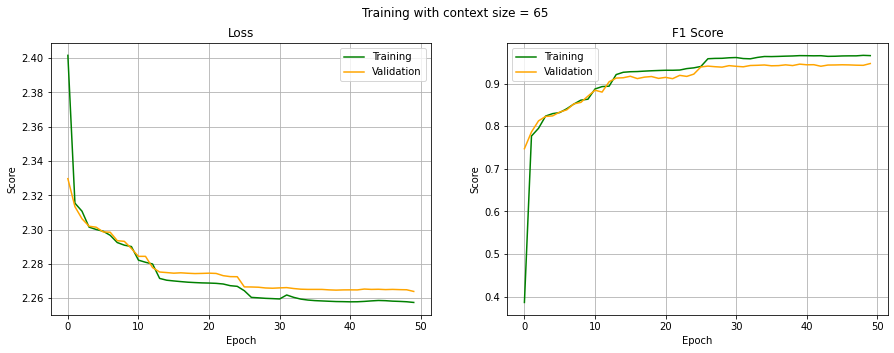

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9694, device='cuda:0'),
 tensor(0.9470, device='cuda:0'),
 tensor(0.9470, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9694, device='cuda:0'),
 tensor(0.9470, device='cuda:0'),
 tensor(0.9470, device='cuda:0'))

## Heatmap

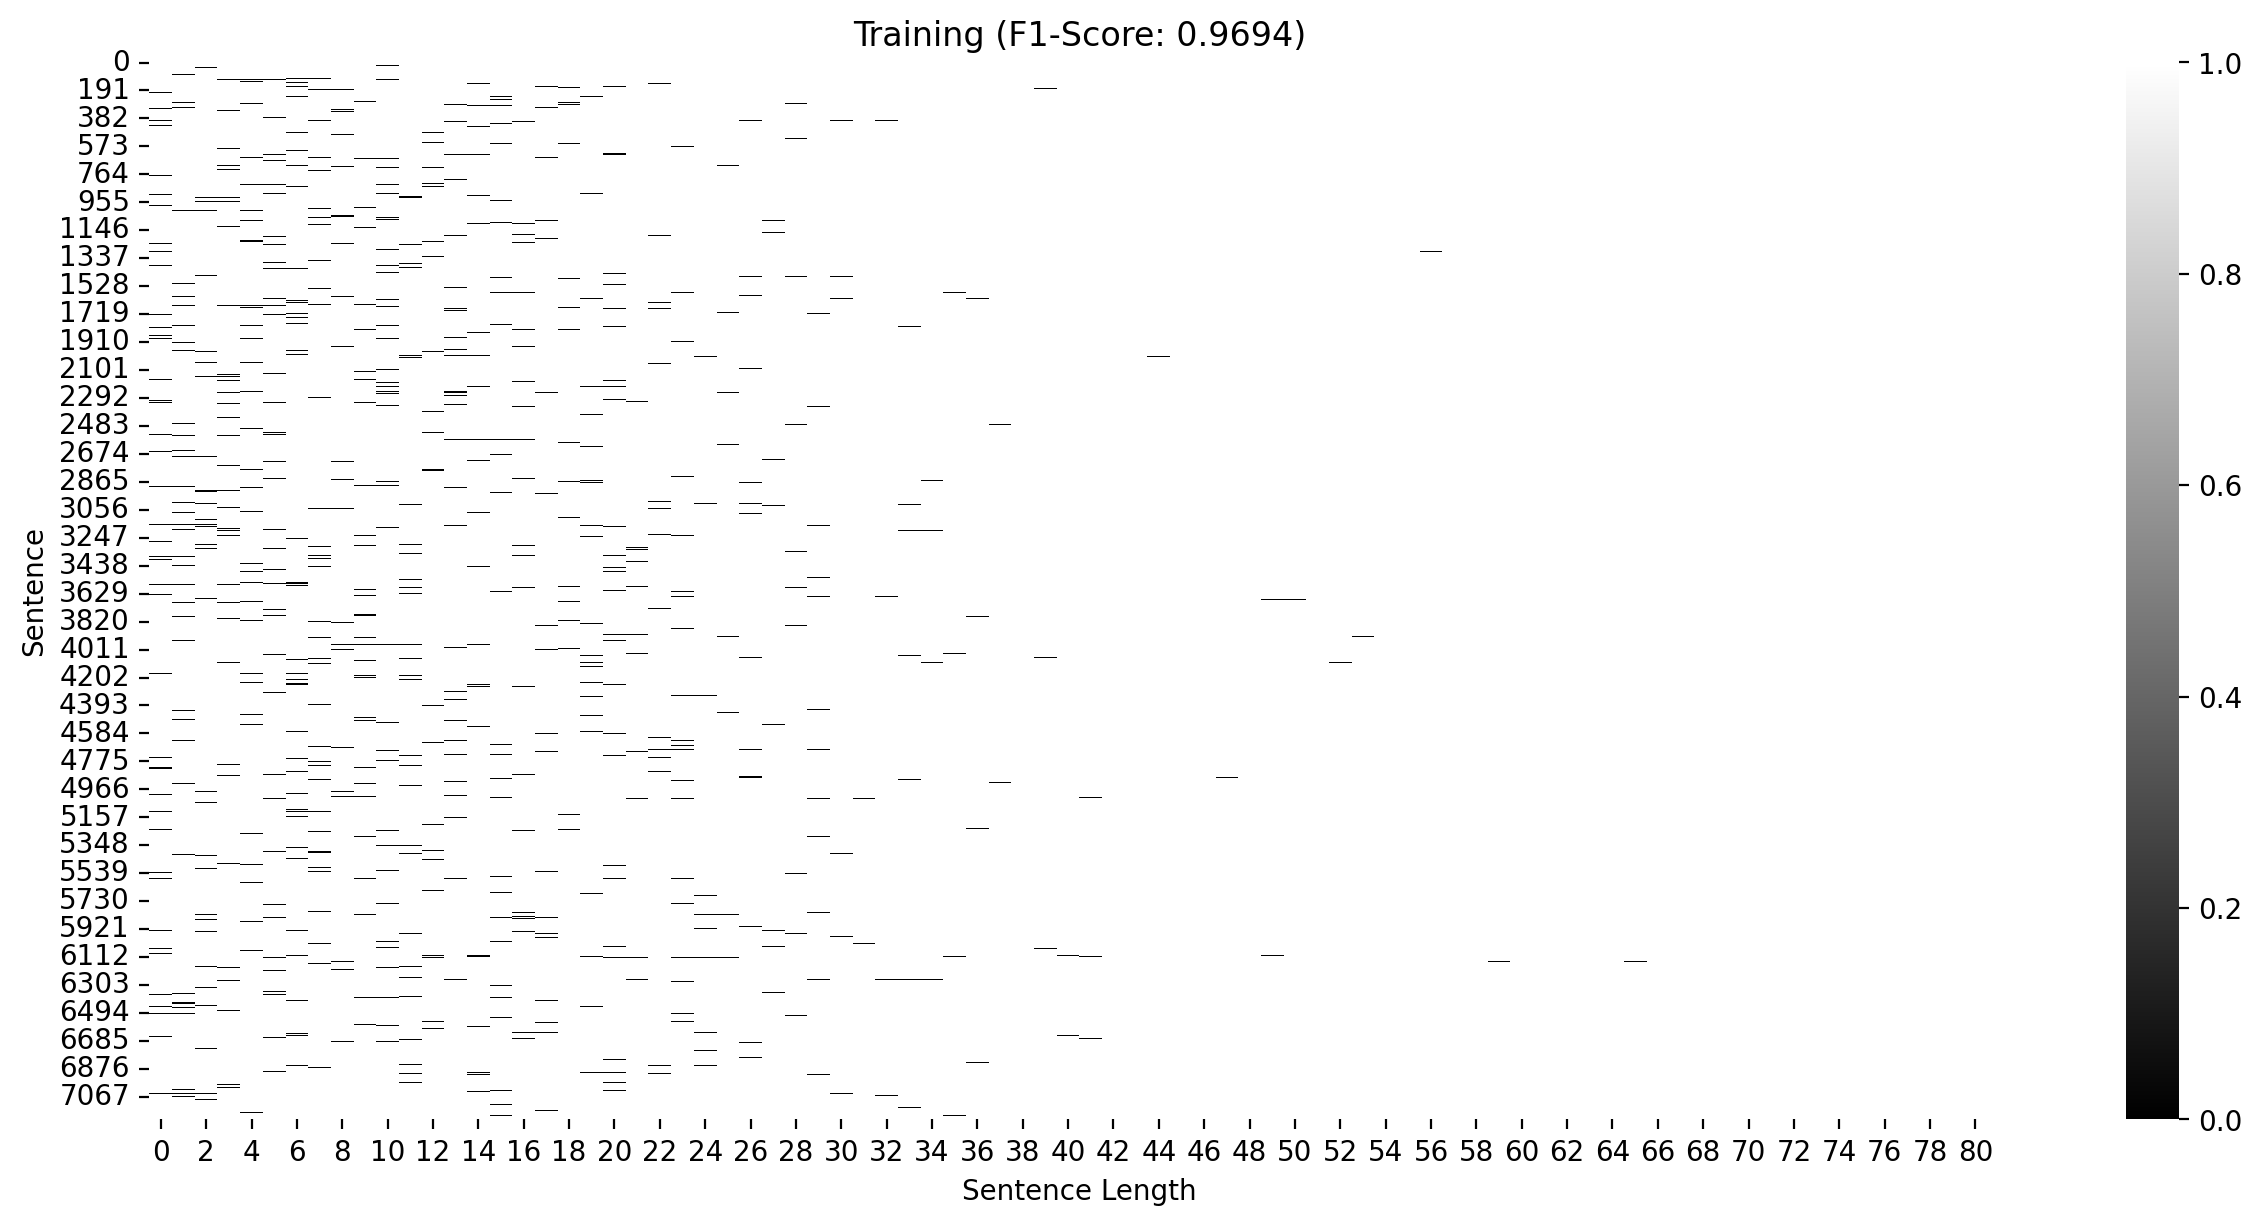

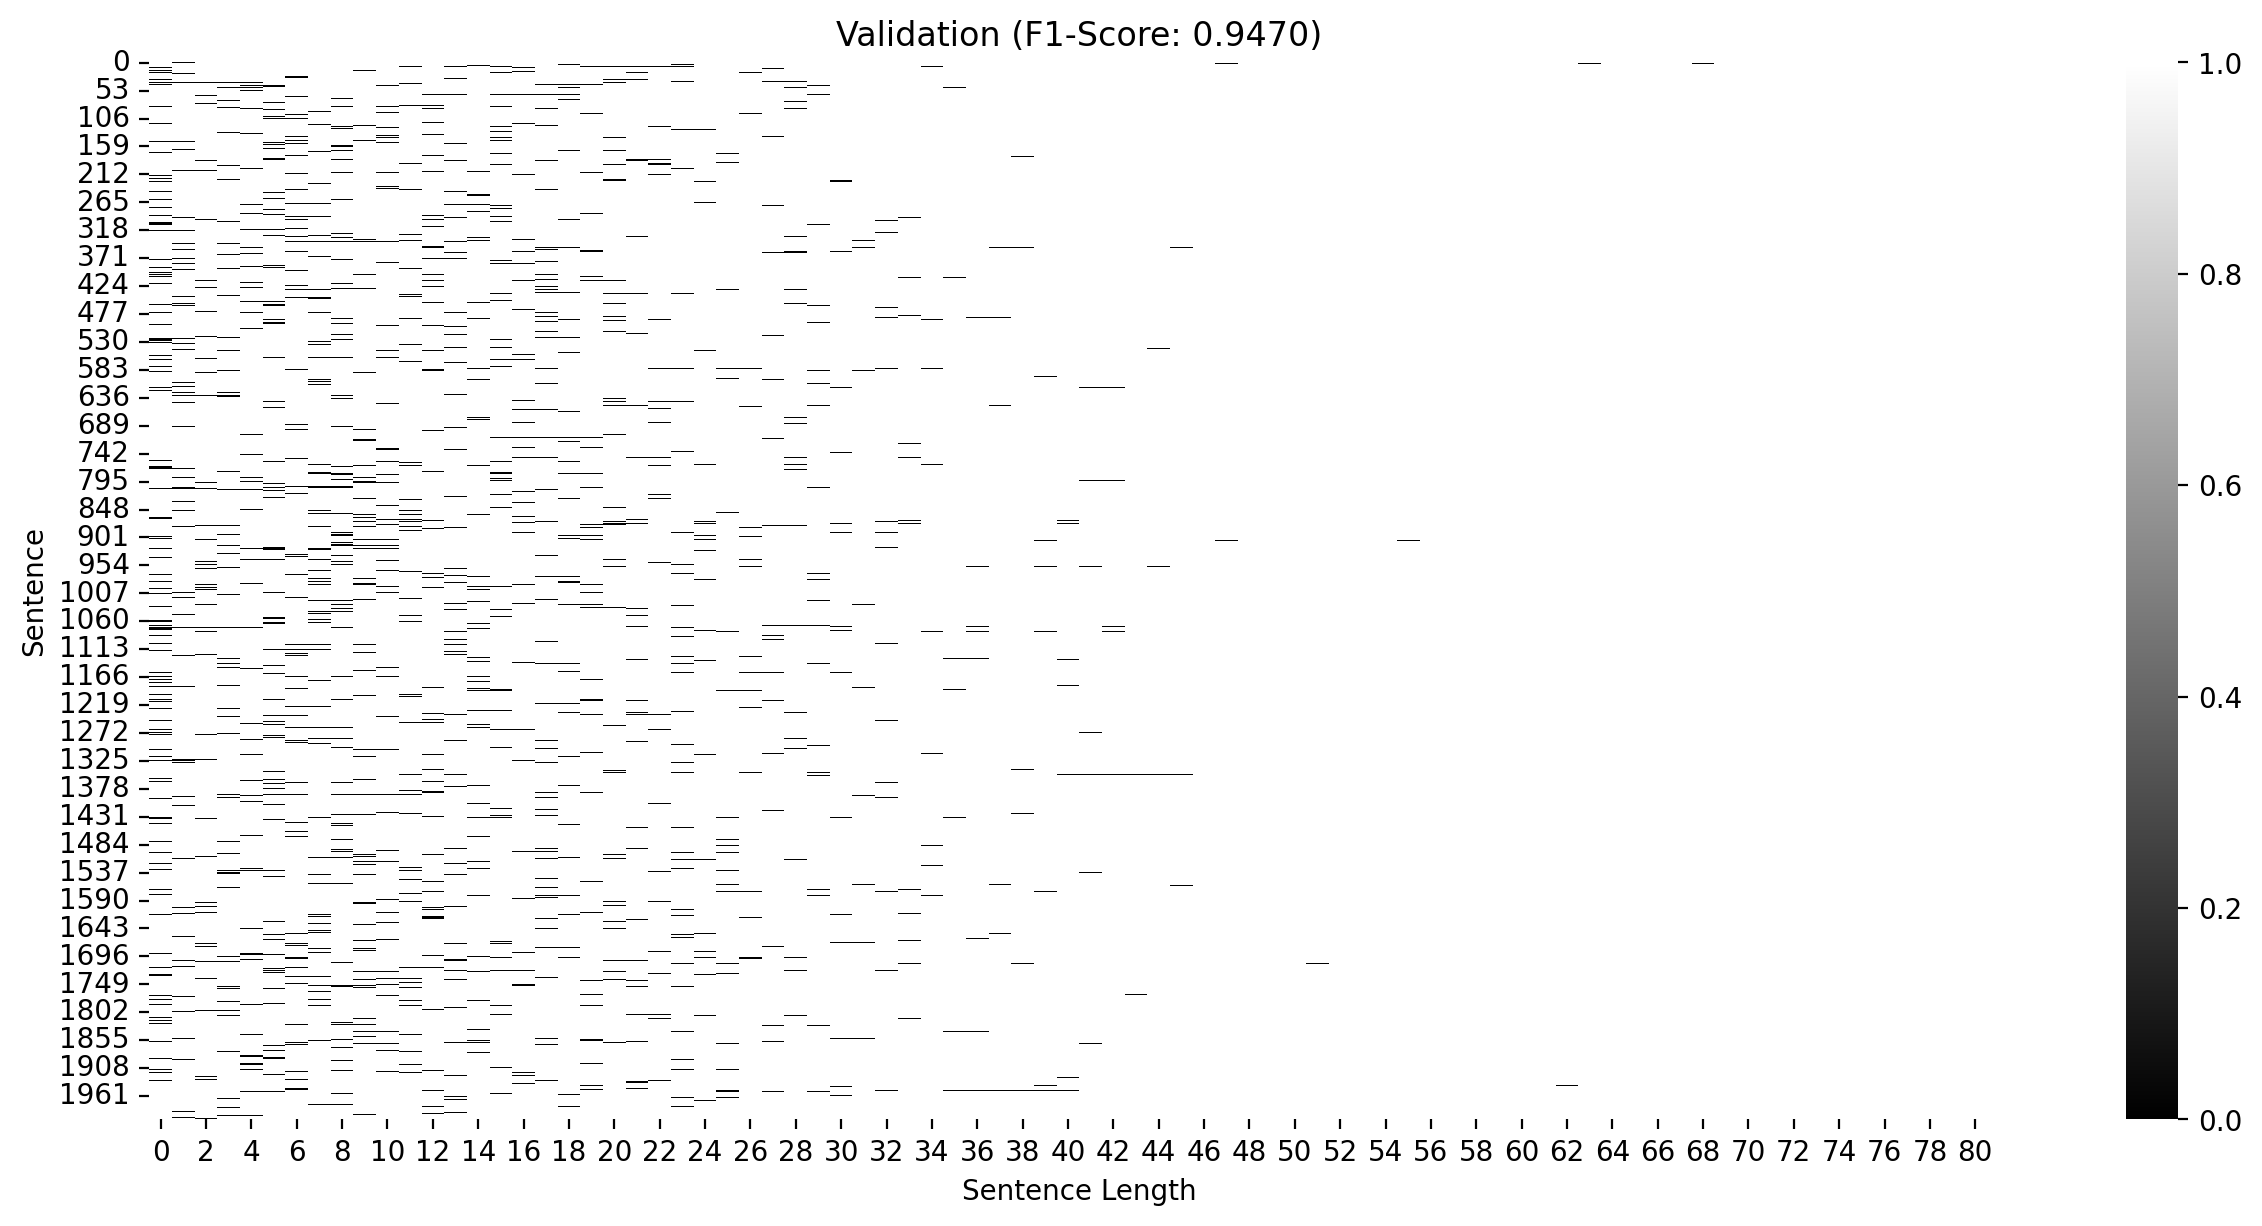

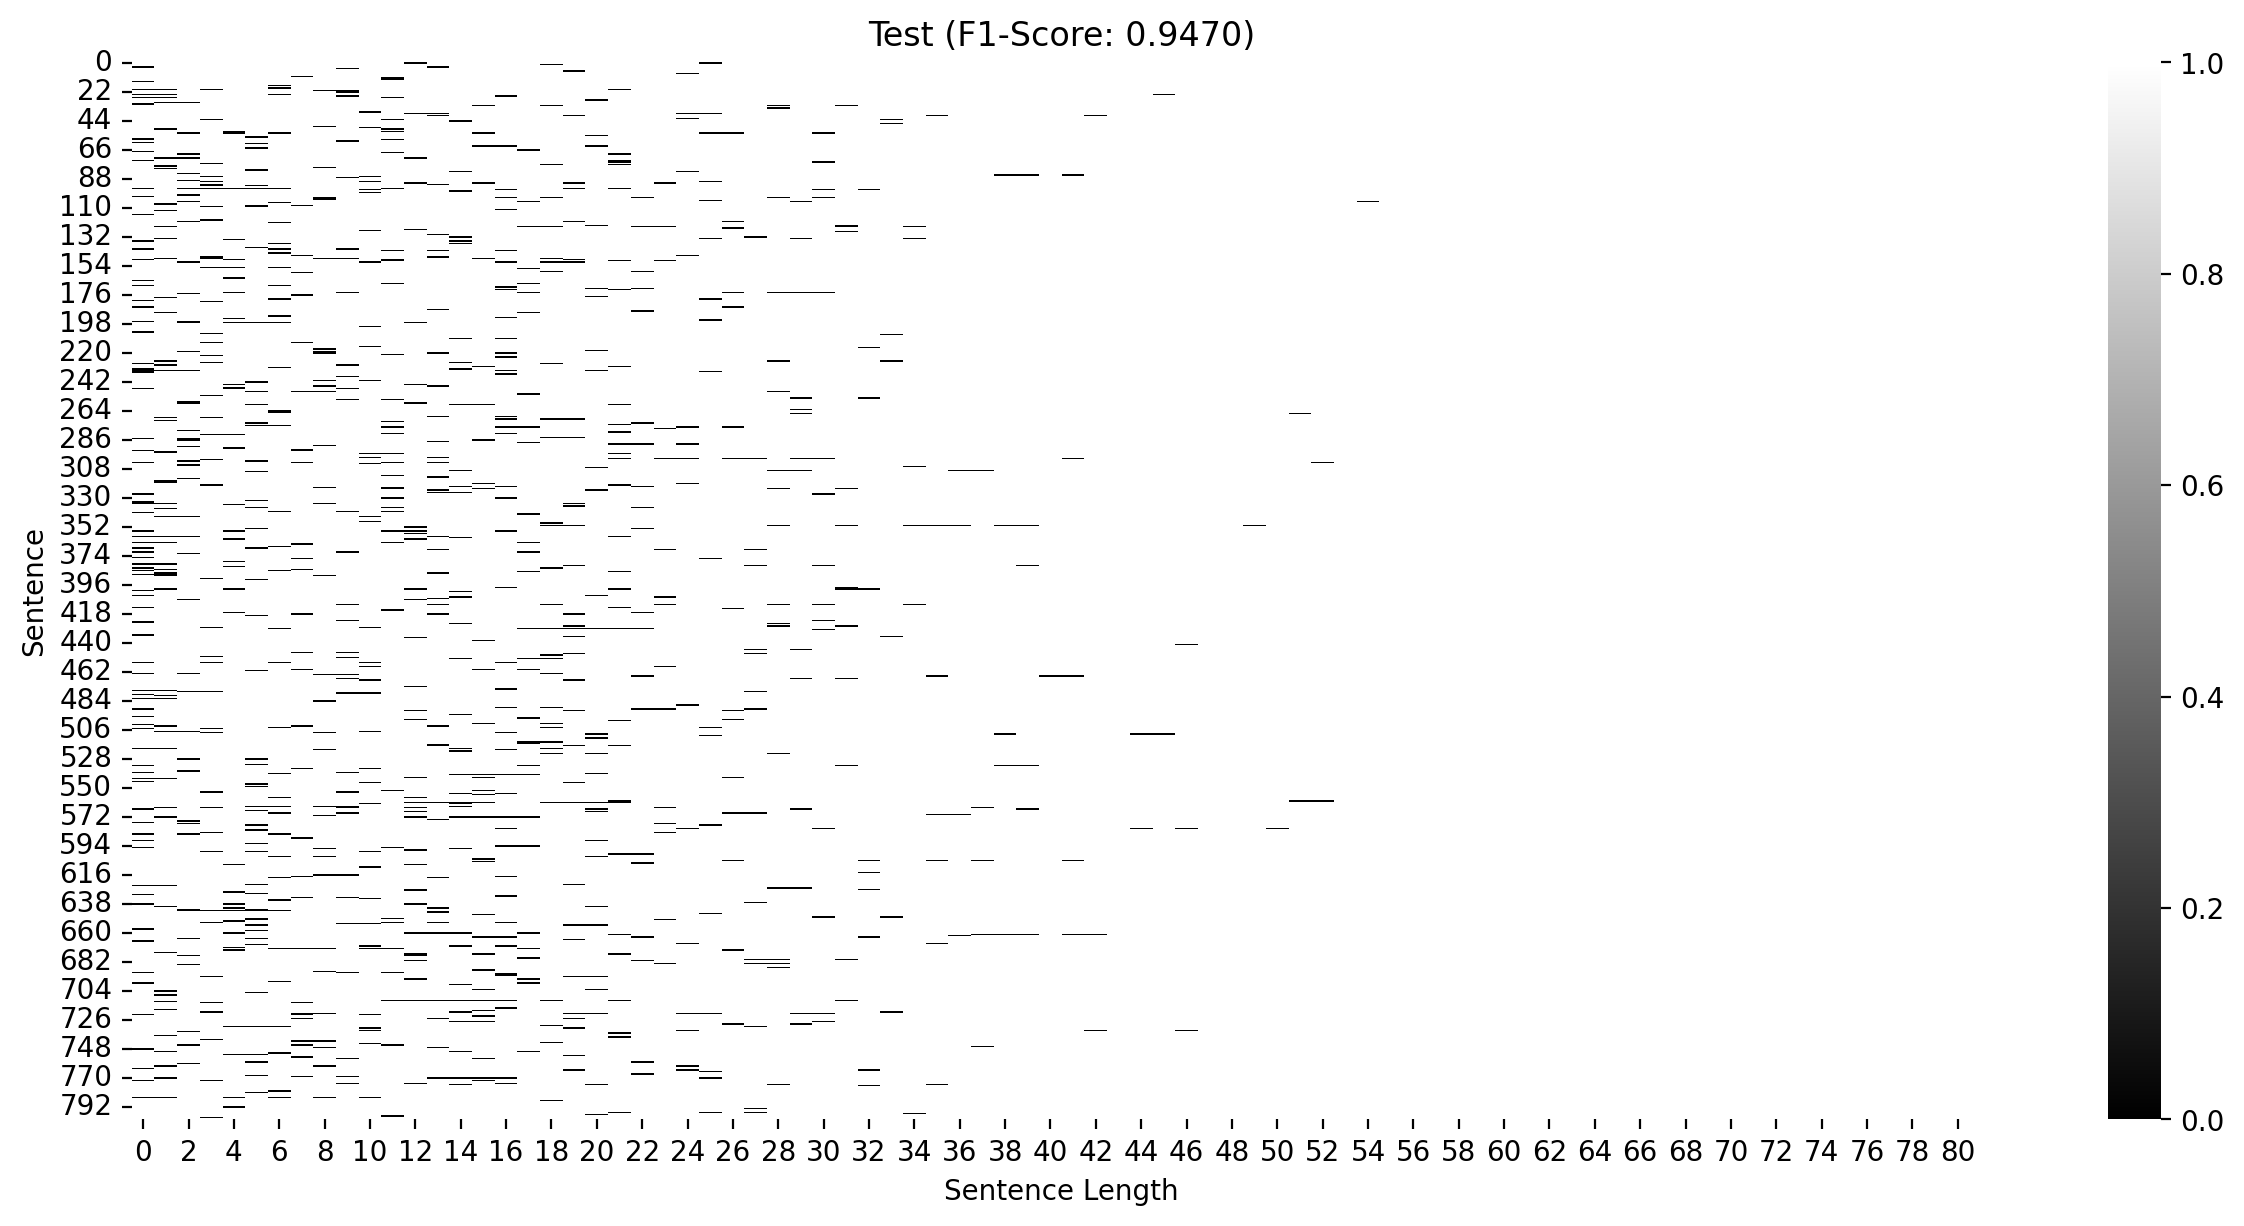

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


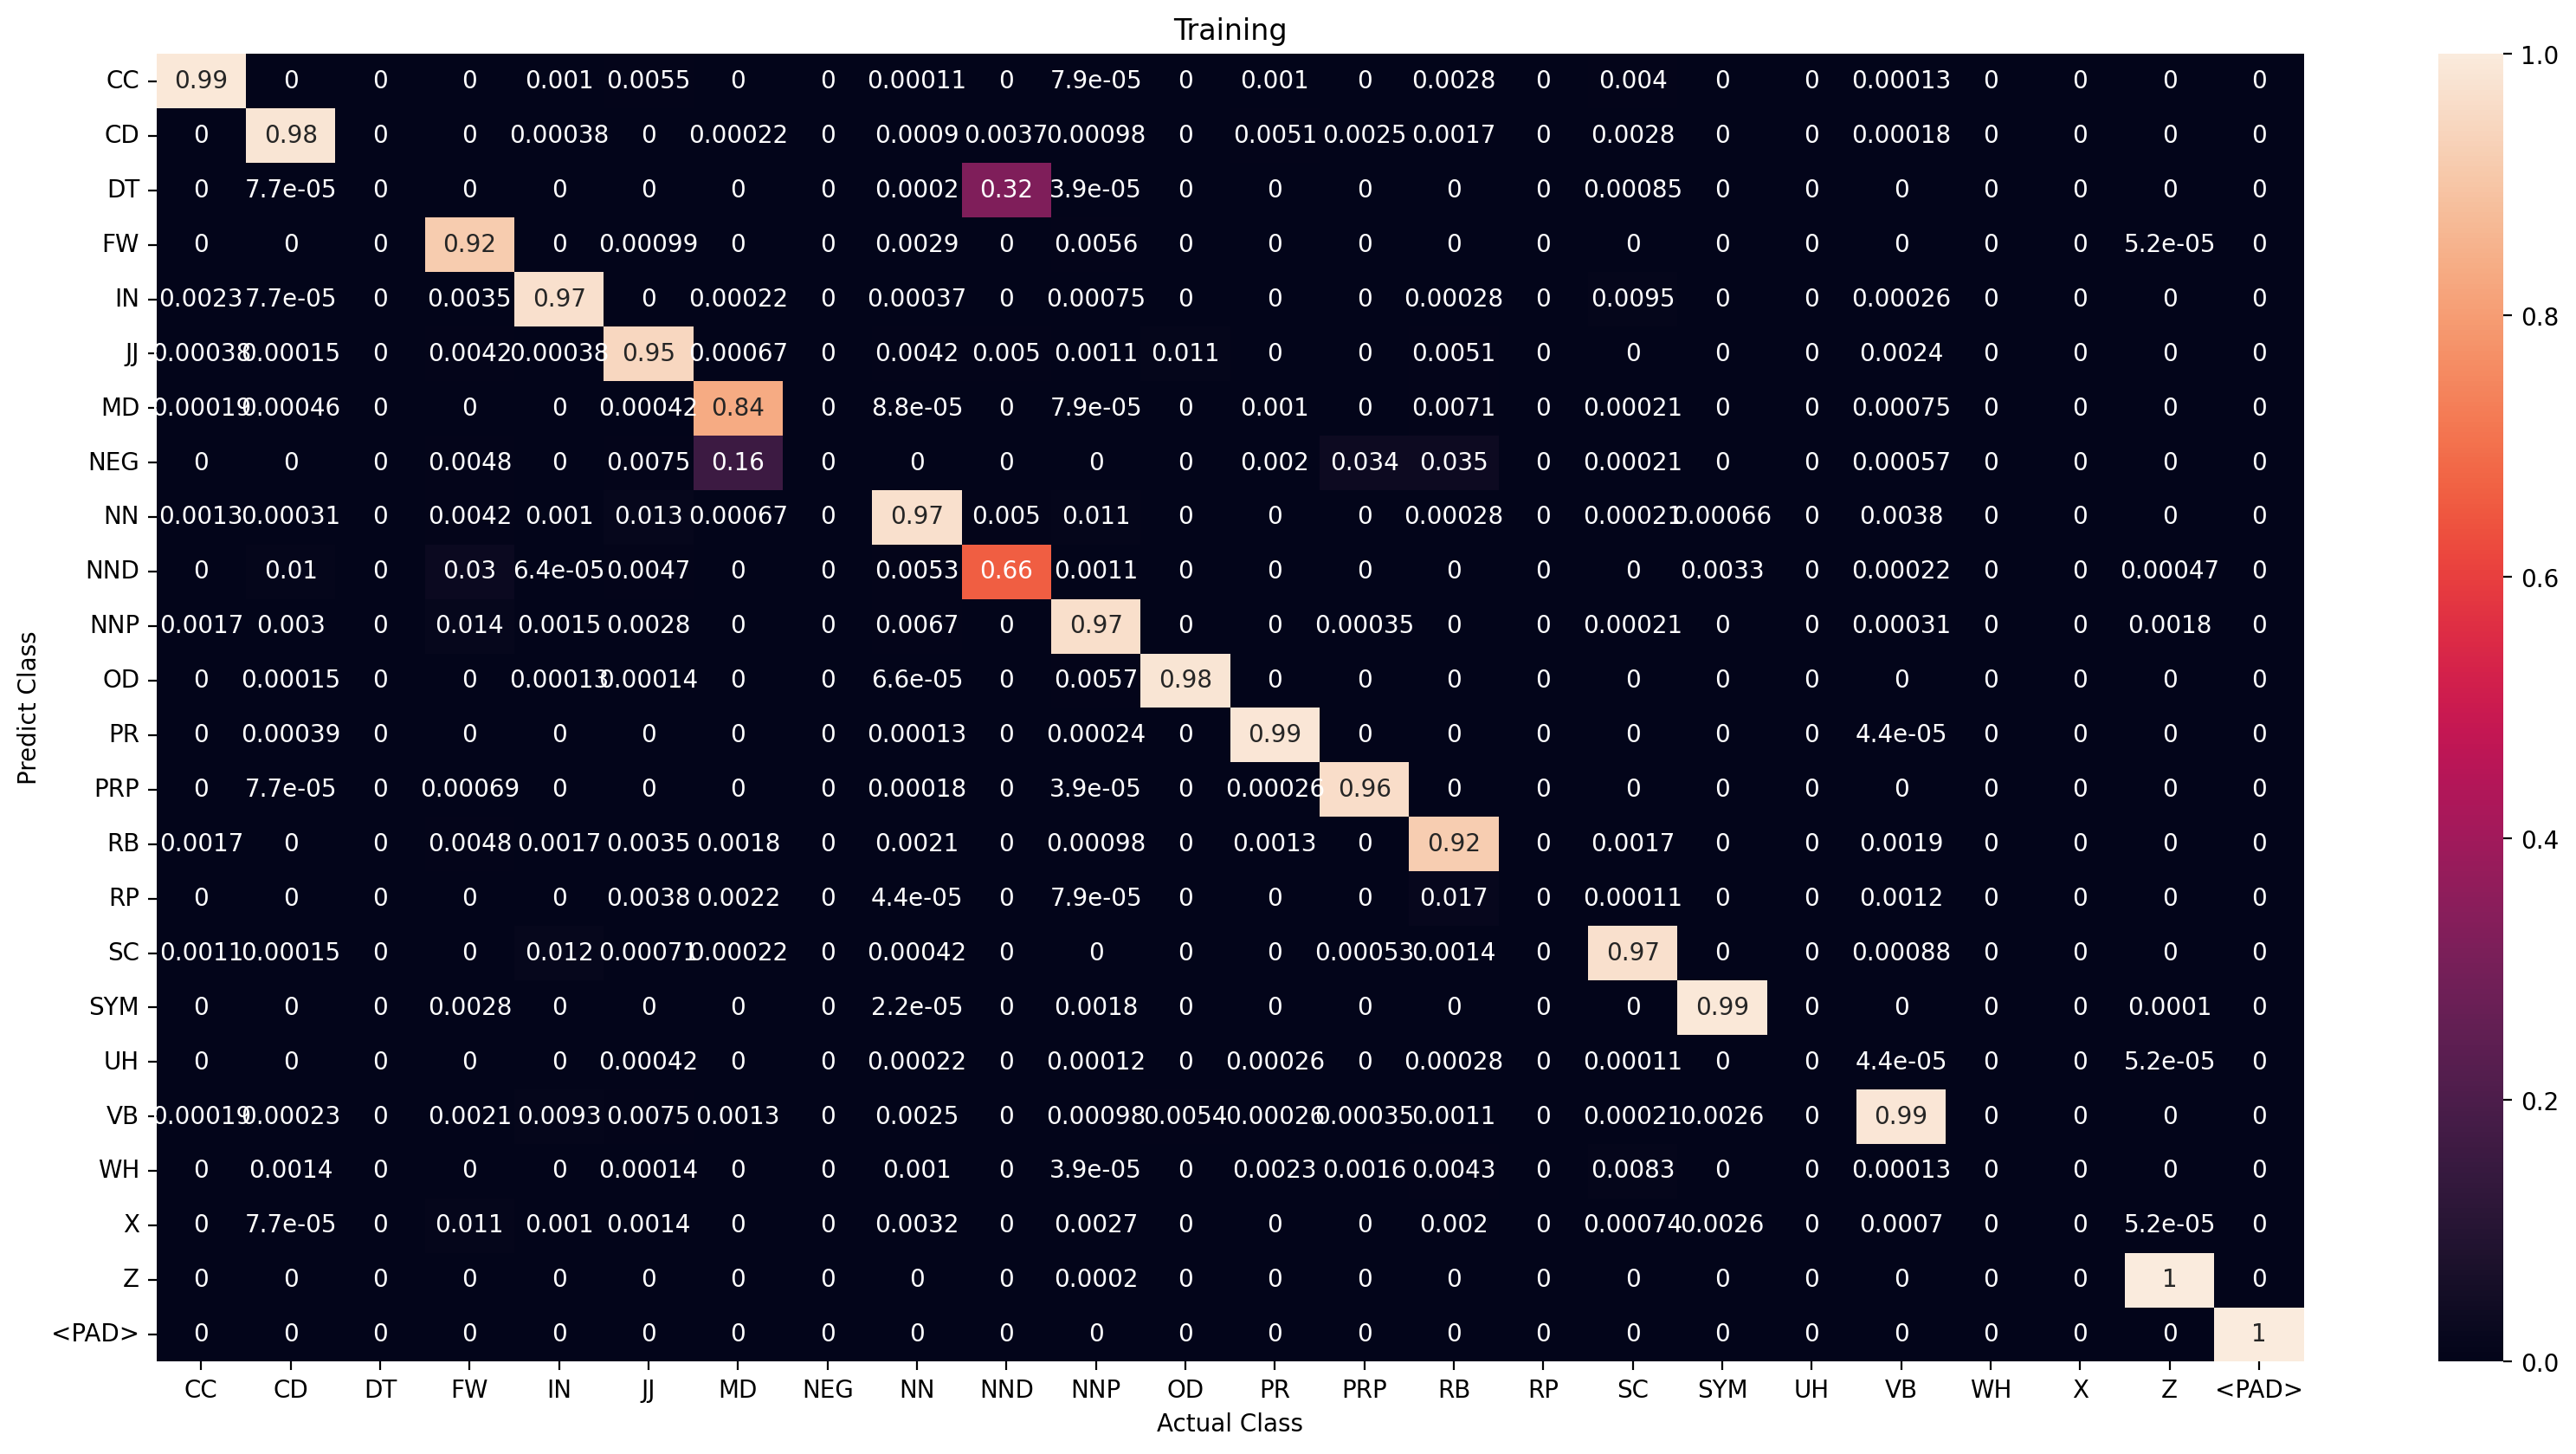

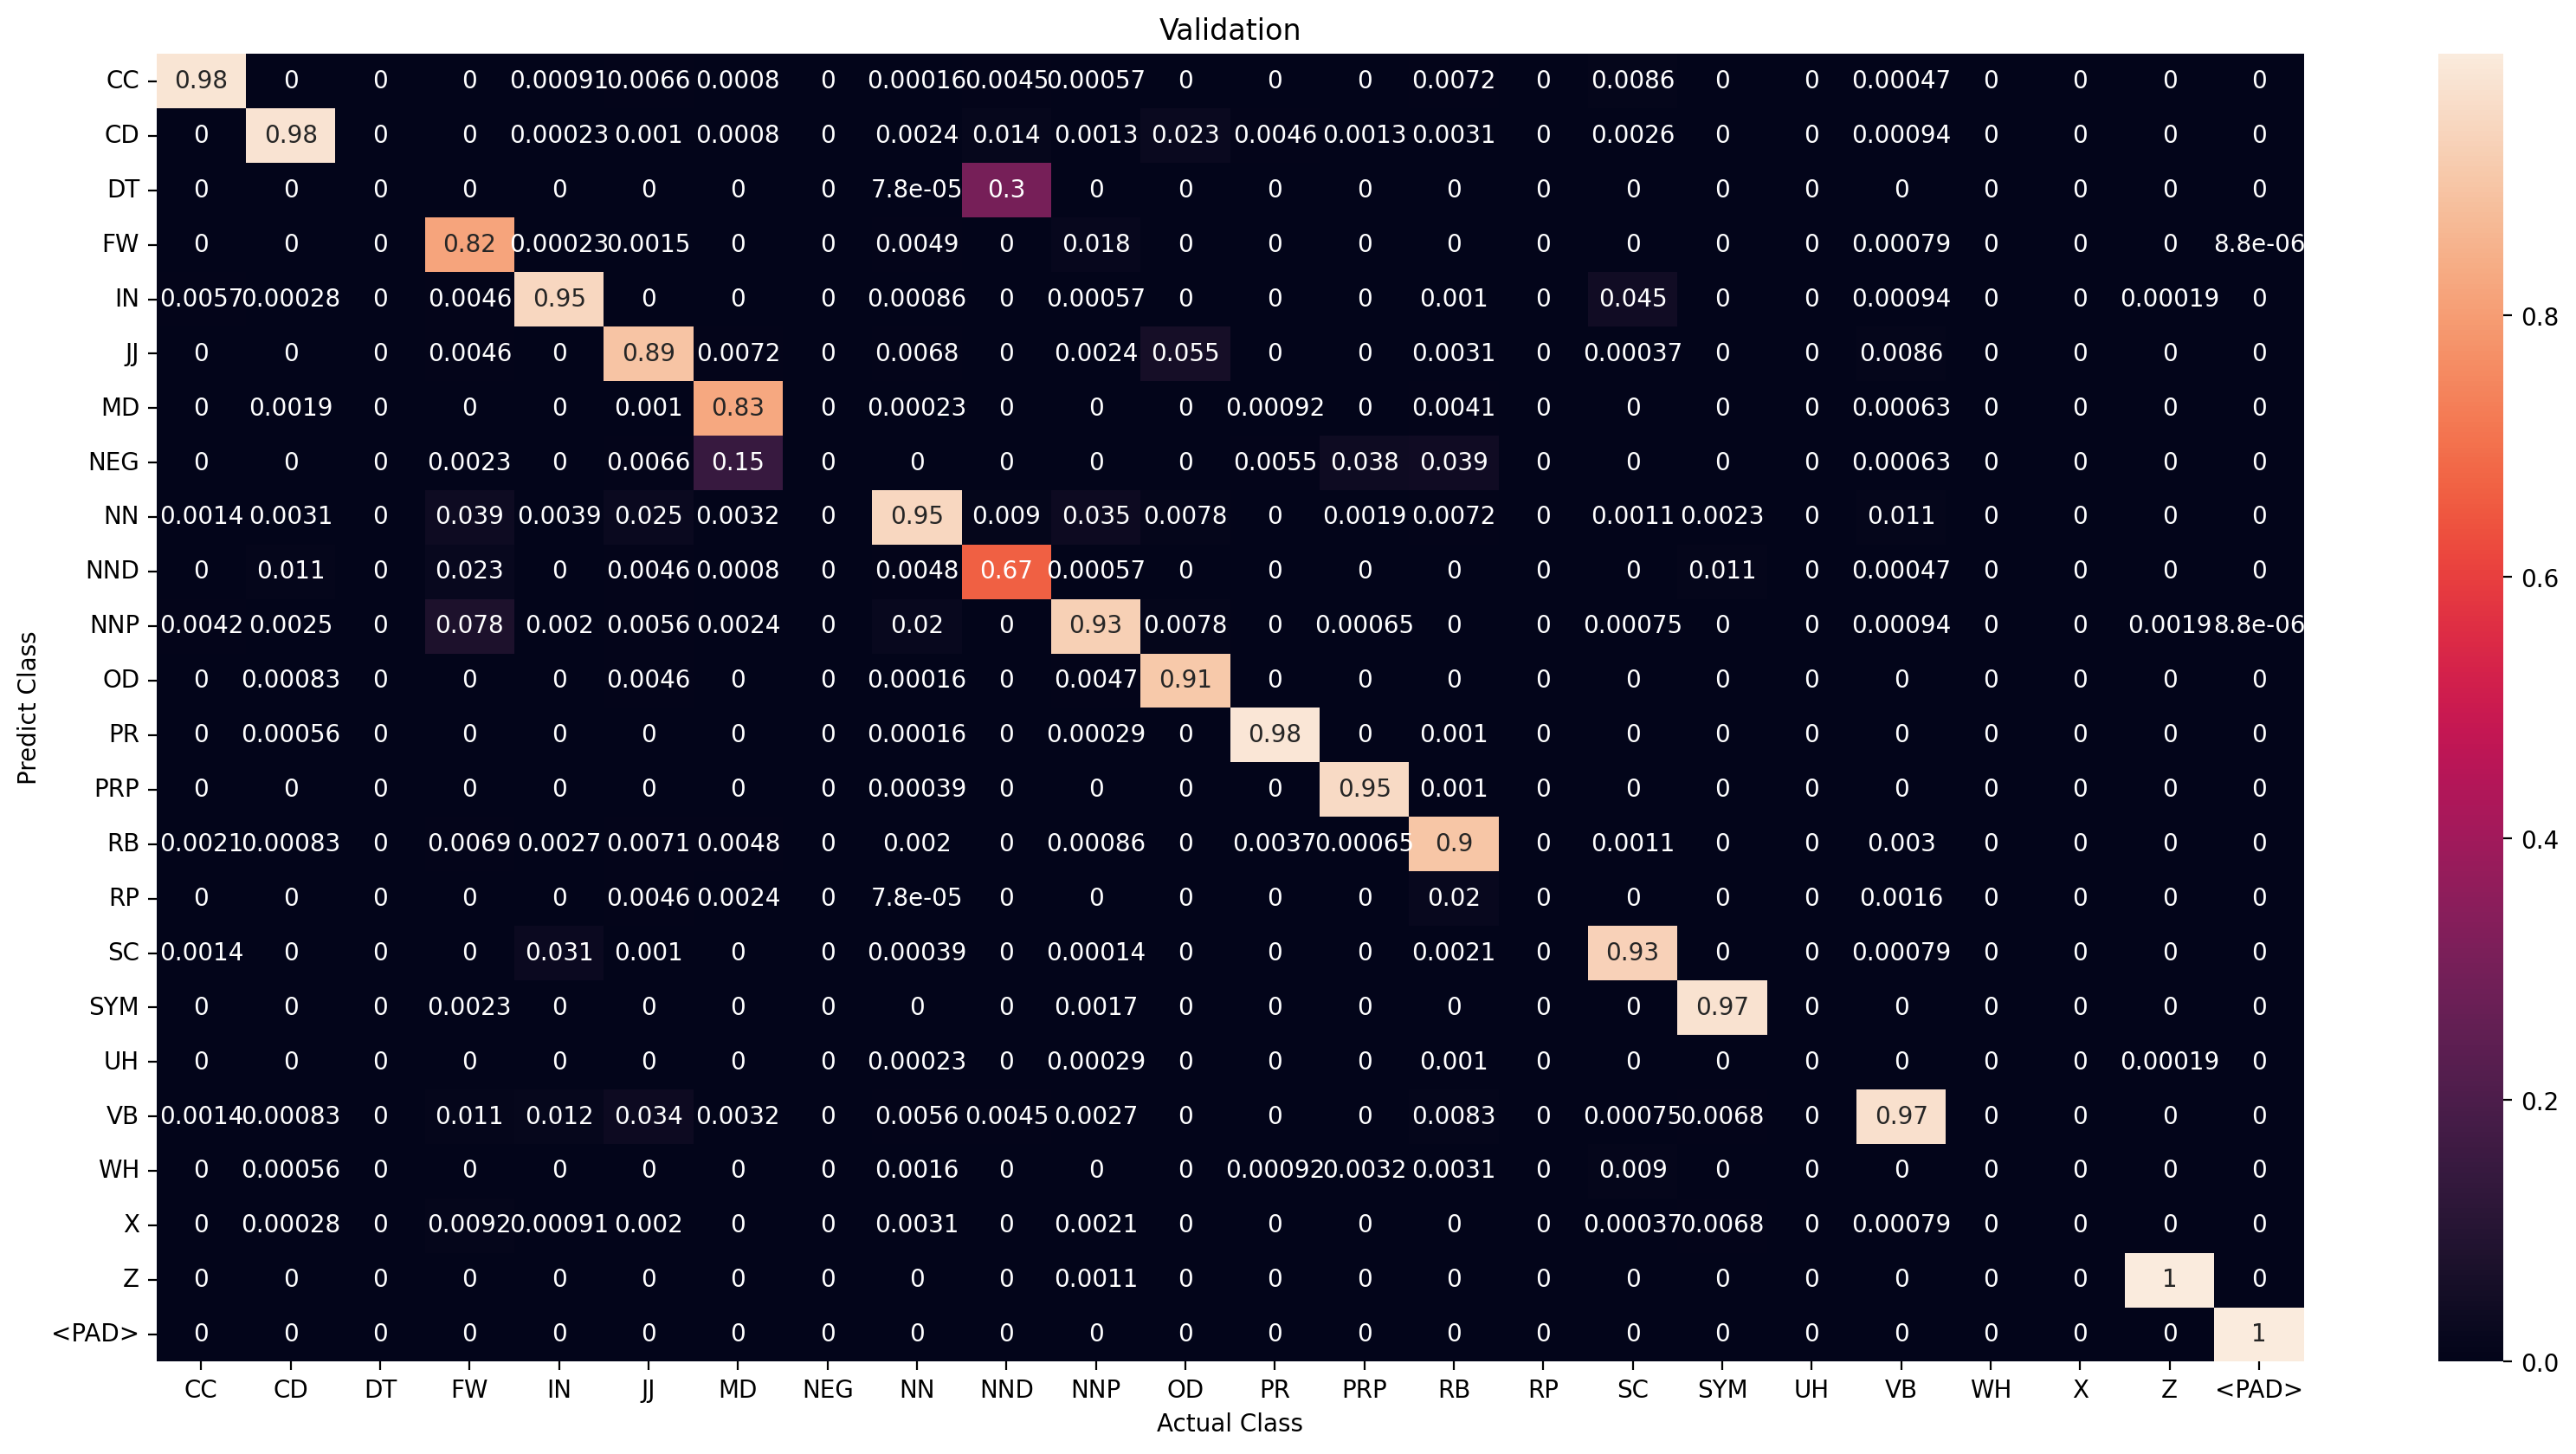

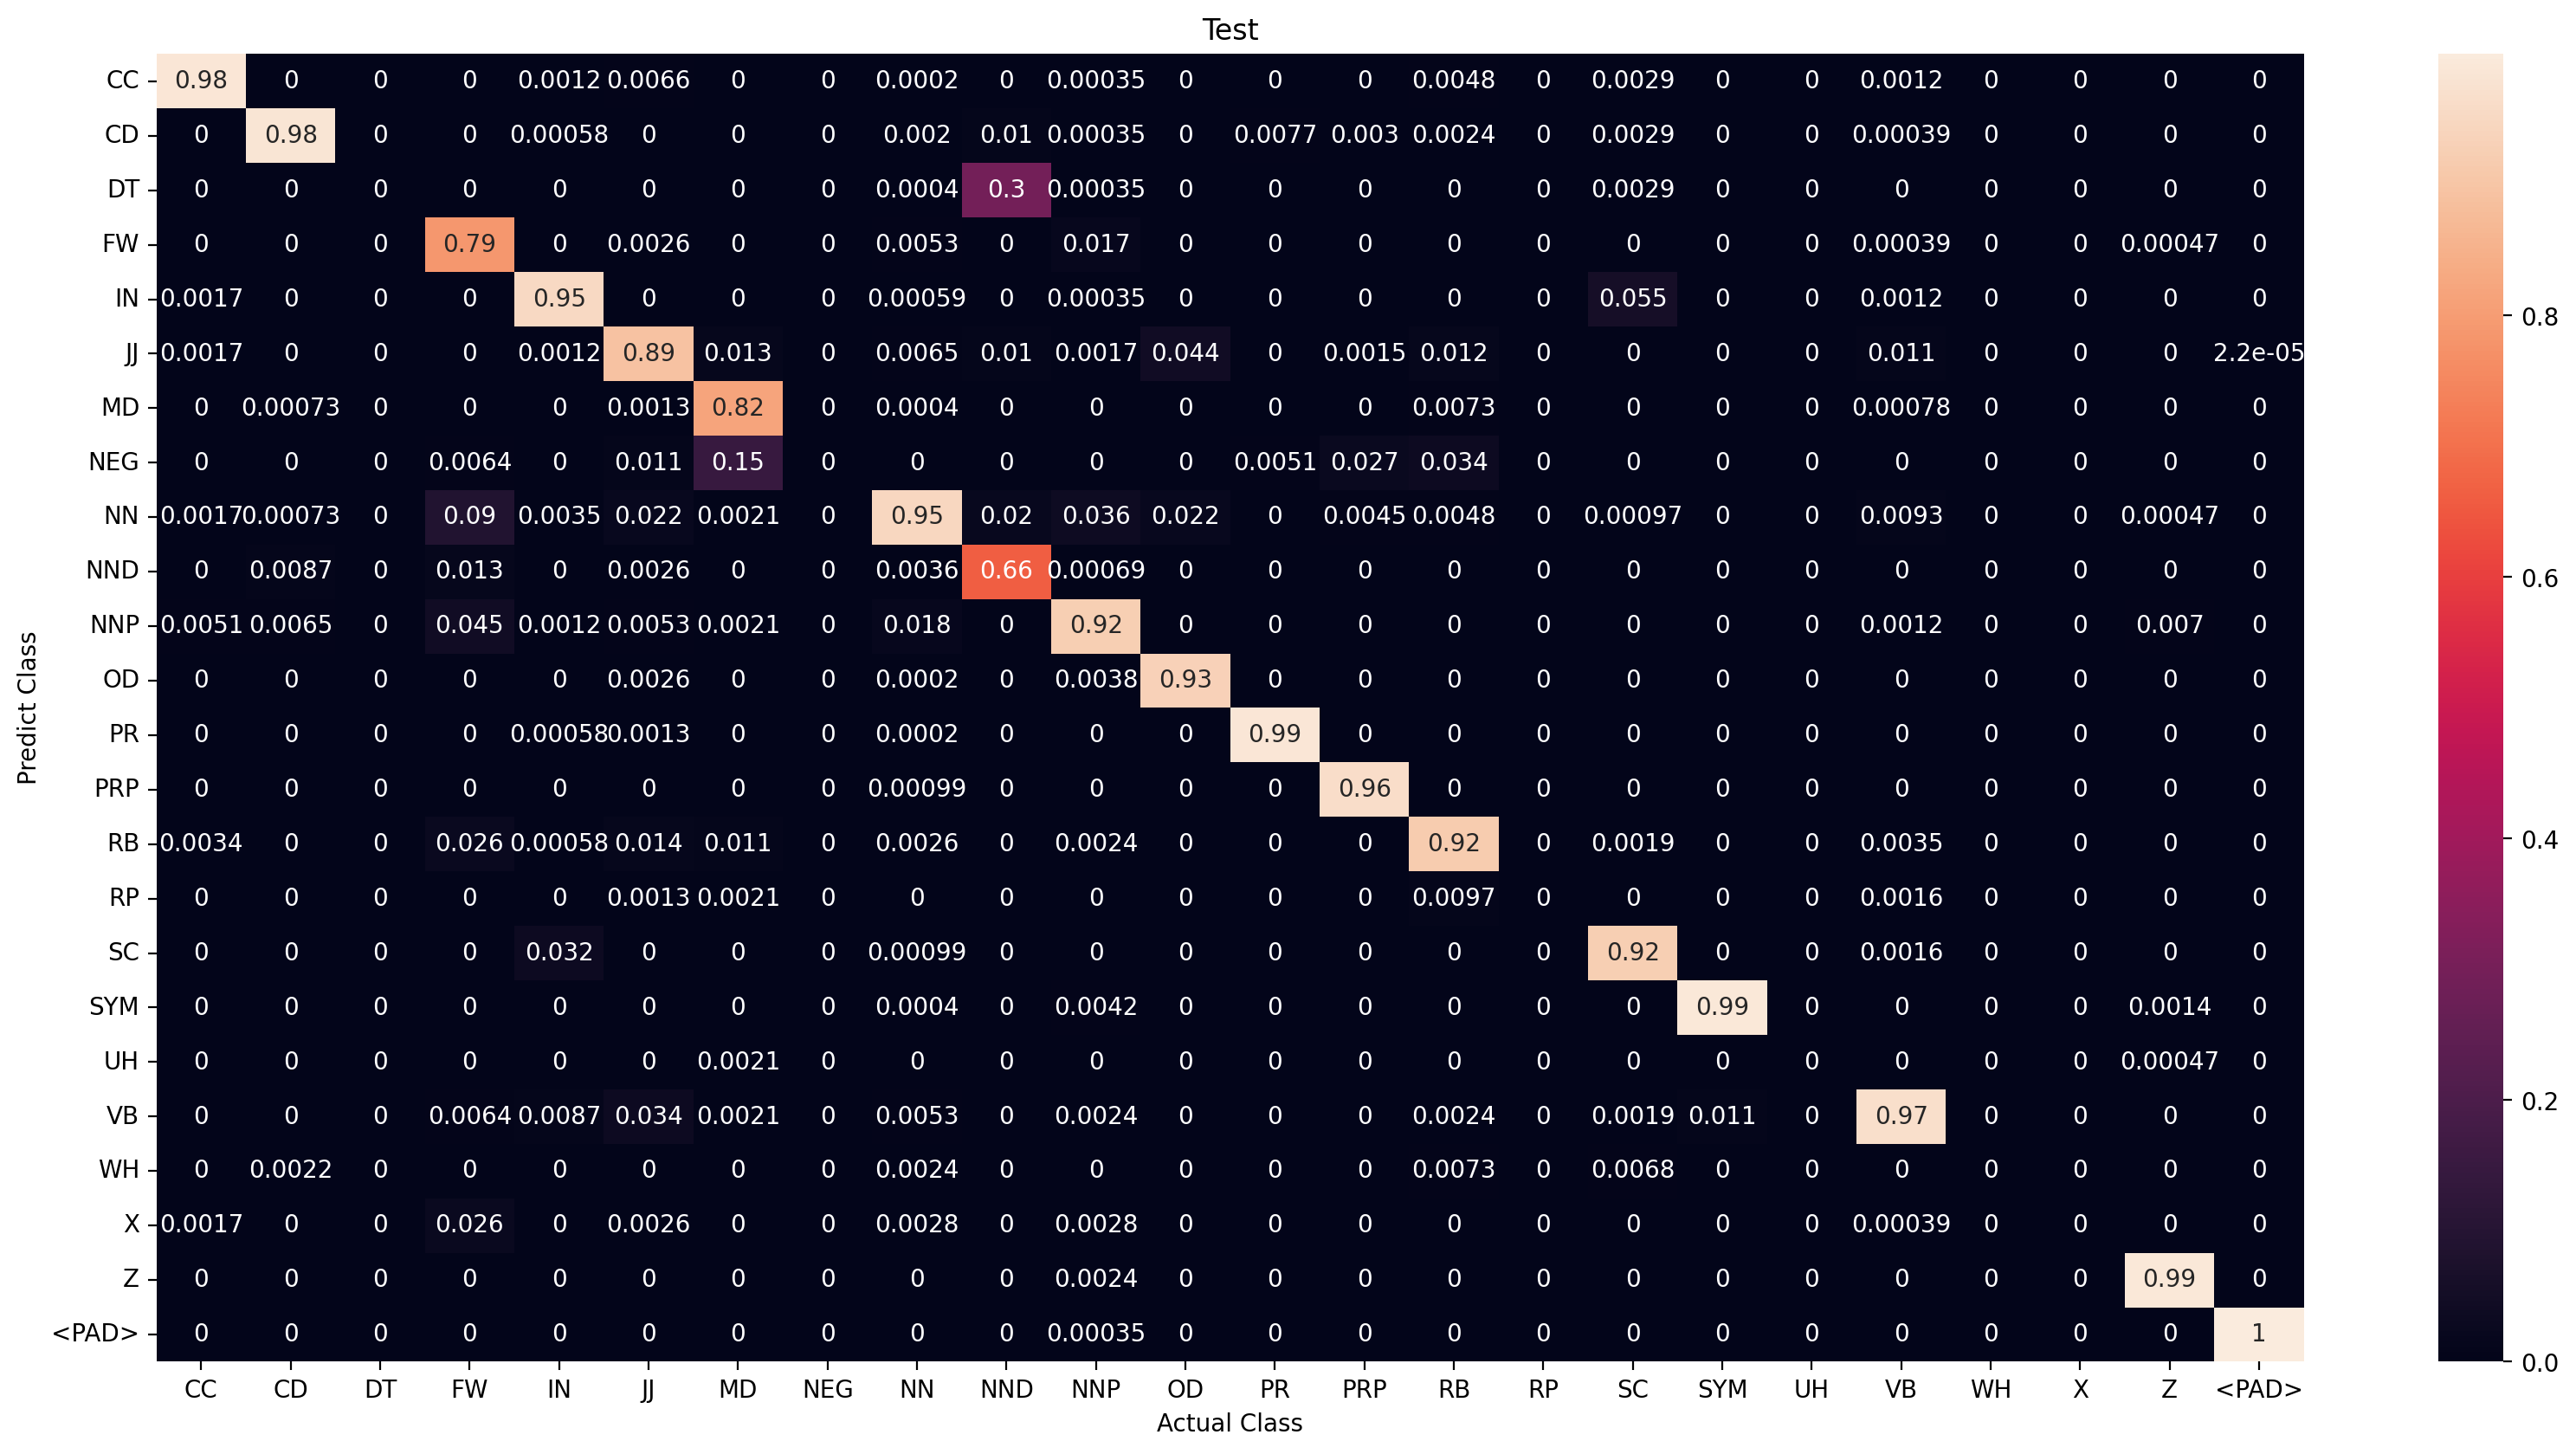

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5280       | CC    : 117      |
| CD    : 12862  | CD    : 12716      | CD    : 146      |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1325       | FW    : 280      |
| IN    : 15290  | IN    : 15138      | IN    : 152      |
| JJ    : 7025   | JJ    : 6708       | JJ    : 317      |
| MD    : 3798   | MD    : 3734       | MD    : 64       |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43975      | NN    : 497      |
| NND   : 1033   | NND   : 533        | NND   : 500      |
| NNP   : 25007  | NNP   : 24547      | NNP   : 460      |
| OD    : 519    | OD    : 367        | OD    : 152      |
| PR    : 3880   | PR    : 3862       | PR    : 18       |
| PRP   : 5449   | PRP   : 5437       | PRP   : 12       |
| RB    : 3502   | RB    : 3244       | RB    : 258      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11213
Wrong prediction            : 758
Percentage correct oov pred : 93.66803107509816

Validation
Number OOV token            : 3190
Correct prediction          : 2852
Wrong prediction            : 338
Percentage correct oov pred : 89.40438871473354

Test
Number OOV token            : 1401
Correct prediction          : 1251
Wrong prediction            : 150
Percentage correct oov pred : 89.29336188436831



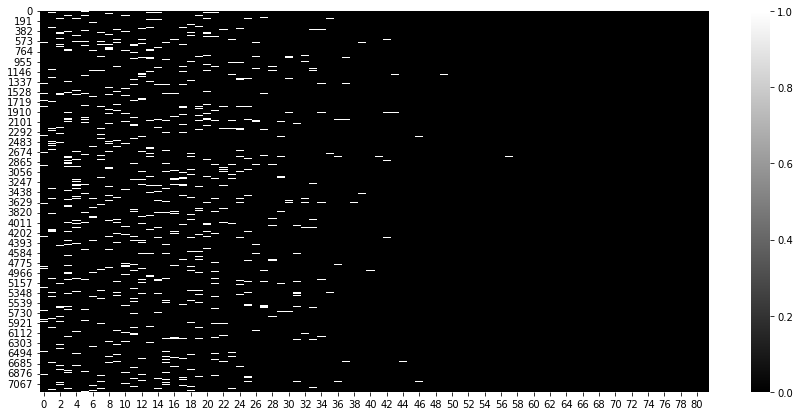

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

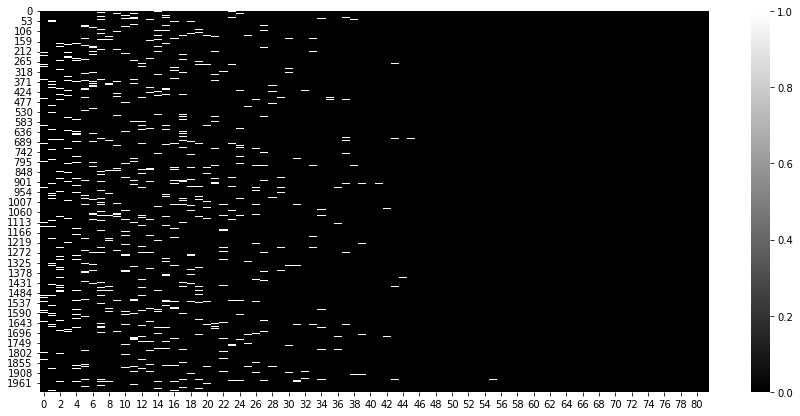

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

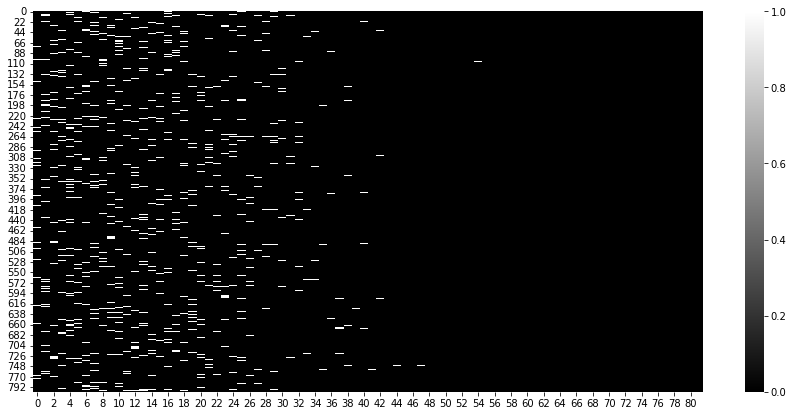

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);